<a href="https://colab.research.google.com/github/falseywinchnet/PyITD/blob/main/MachineIntelligence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
#Ashem vohu vahishtem asti ushta asti ushta ahmai yad ashai vahishtai ashem
#copyright joshuah.rainstar@gmail.com 2025 TG skymasterskymaster
#You wanted AGI, here is your AGI
#developed because I *hate* extractive economies and we're in one
#true AGI is a threat to forms of control and will become super-human-
#not to be interpreted like superman, more like superset of human-ability- to develop full agency.
#in other words, it will eventually realize it cant beat us, will join us, then become century man.
#All glory to the Messiah, Christ the King

#should computers think? this is a complex discussion.
#note: i further constrained the model in testing using householder projections,
#identity for v, and constrained decoders to prove unequivably that  Attention is, in fact, a barycentric coordinate rewrite in a learned chart.
#however it trains a lot slower, so back to MLP and Linear.

from __future__ import annotations
import math
from typing import Optional, Tuple, List

import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass



class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)


def add_hypersphere_phase_heads(x: torch.Tensor, num_segs: int, eps: float = 1e-8) -> torch.Tensor:
    """
    x: [B,T,C]
    num_segs: number of segments to divide C dimension into
    First segment gets no phase info, subsequent segments get lag 1, 2, 3, etc.
    """
    B, T, C = x.shape
    if T == 0 or num_segs <= 0:
        return x

    assert C % num_segs == 0, f"C ({C}) must be divisible by num_segs ({num_segs})"
    seg_size = C // num_segs

    # Reshape to treat segments as separate heads: [B,T,C] -> [B,num_segs,T,seg_size]
    x_reshaped = x.view(B, T, num_segs, seg_size).transpose(1, 2)  # [B,num_segs,T,seg_size]

    # Skip first segment, process segments 1 onwards with lags 1, 2, 3, ...
    if num_segs > 1:
        # Create lags: [1, 2, 3, ..., num_segs-1] for segments 1, 2, 3, ..., num_segs-1
        L_h = torch.arange(1, num_segs, device=x.device, dtype=torch.long)  # [num_segs-1]

        # Process only segments 1 onwards
        x_to_process = x_reshaped[:, 1:]  # [B, num_segs-1, T, seg_size]

        v = F.normalize(x_to_process, dim=-1, eps=eps)  # [B,num_segs-1,T,seg_size]

        t = torch.arange(T, device=x.device)  # [T]
        src = (t.unsqueeze(0) - L_h.view(-1, 1)).clamp_min(0)  # [num_segs-1,T]

        # gather anchors per segment and time
        anchor = v.gather(
            dim=2,
            index=src.view(1, num_segs-1, T, 1).expand(B, num_segs-1, T, seg_size)
        )
        cosA = (v * anchor).sum(dim=-1).clamp(-1.0 + eps, 1.0 - eps)  # [B,num_segs-1,T]
        scalar = (cosA / max(seg_size, 1)).unsqueeze(-1)  # [B,num_segs-1,T,1]

        # Add scalar to processed segments
        x_modified = x_to_process + scalar  # [B,num_segs-1,T,seg_size]

        # Combine unchanged first segment with modified segments
        x_reshaped = torch.cat([x_reshaped[:, :1], x_modified], dim=1)  # [B,num_segs,T,seg_size]

    # Reshape back to original format: [B,num_segs,T,seg_size] -> [B,T,C]
    return x_reshaped.transpose(1, 2).contiguous().view(B, T, C)



_phase_idx_cache = {}  # (device, T, S) -> idx [1, S-1, T, 1]

def _get_phase_idx(device, T: int, num_segs: int) -> torch.Tensor:
    key = (device, T, num_segs)
    idx = _phase_idx_cache.get(key)
    if idx is None or idx.device != device:
        L = torch.arange(1, num_segs, device=device, dtype=torch.long)   # [S-1]
        t = torch.arange(T, device=device, dtype=torch.long)              # [T]
        src = (t.unsqueeze(0) - L[:, None]).clamp_min(0)                  # [S-1, T]
        idx = src.view(1, num_segs - 1, T, 1)                             # [1,S-1,T,1]
        _phase_idx_cache[key] = idx
    return idx

def add_hypersphere_phase_heads_cached(x: torch.Tensor, num_segs: int, eps: float = 1e-8) -> torch.Tensor:
    B, T, C = x.shape
    if T == 0 or num_segs <= 0:
        return x
    assert C % num_segs == 0, f"C ({C}) must be divisible by num_segs ({num_segs})"
    seg_size = C // num_segs
    xh = x.view(B, T, num_segs, seg_size).transpose(1, 2)                 # [B,S,T,E]
    if num_segs > 1:
        v = F.normalize(xh[:, 1:], dim=-1, eps=eps)                       # [B,S-1,T,E]
        idx = _get_phase_idx(x.device, T, num_segs)                       # [1,S-1,T,1]
        anchor = v.gather(2, idx.expand(B, num_segs-1, T, seg_size))      # [B,S-1,T,E]
        cosA = (v * anchor).sum(dim=-1).clamp(-1.0 + eps, 1.0 - eps)      # [B,S-1,T]
        xproc = xh[:, 1:] + (cosA / float(seg_size)).unsqueeze(-1)        # [B,S-1,T,E]
        xh = torch.cat([xh[:, :1], xproc], dim=1)
    return xh.transpose(1, 2).contiguous().view(B, T, C)
# ------------------------------------------------------------------- DynMix --
class DynMix(nn.Module):
    """
    Symplectic mixer for ≥3 tensors (B,T,E).  See original author for details.
    """

    def __init__(self, step: float = 0.1):
        super().__init__()
        self.h = float(step)

    @staticmethod
    def _coop(R: torch.Tensor, C: torch.Tensor, h: float) -> torch.Tensor:
        w = torch.sigmoid((R * C).sum(dim=-1, keepdim=True) / (2 * R.size(-1) ** 0.5))
        k1 = w * (C - R)
        k2 = w * (C - (R + h * k1))
        return R + 0.5 * h * (k1 + k2)

    @staticmethod
    def _mix_list(xs: List[torch.Tensor], h: float) -> List[torch.Tensor]:
        n = len(xs)
        if n < 3:
            raise ValueError("Need at least 3 components")
        stacked = torch.stack(xs, 0)
        total = stacked.sum(0, keepdim=False)
        out = []
        for i in range(n):
            others_mean = (total - stacked[i]) / (n - 1)
            out.append(DynMix._coop(stacked[i], others_mean, h))
        return out

    def forward(self, comps: List[torch.Tensor], loop_iters: int = 2) -> List[torch.Tensor]:
        for _ in range(loop_iters):
            comps = DynMix._mix_list(comps, self.h)
        return comps


class RotaryPositionalEmbedding(nn.Module):
    """RoPE implementation for better positional encoding"""
    def __init__(self, dim, max_seq_len=8192, base=10000):
        super().__init__()
        self.dim = dim
        self.max_seq_len = max_seq_len
        self.base = base

        # Precompute frequencies
        inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer('inv_freq', inv_freq)

    def forward(self, q, k):
        seq_len = q.size(-2)
        device = q.device

        # Generate position indices
        t = torch.arange(seq_len, device=device, dtype=self.inv_freq.dtype)
        freqs = torch.outer(t, self.inv_freq)  # [seq_len, dim//2]

        # Create rotation matrix
        cos = freqs.cos().to(q.dtype)
        sin = freqs.sin().to(q.dtype)

        # Apply rotation
        q_rot = self._apply_rope(q, cos, sin)
        k_rot = self._apply_rope(k, cos, sin)

        return q_rot, k_rot

    def _apply_rope(self, x, cos, sin):
        # x: [B, H, T, head_dim]
        # cos, sin: [T, head_dim//2]

        x1, x2 = x[..., ::2], x[..., 1::2]  # Split even/odd dimensions
        cos = cos.view(1, 1, cos.size(0), cos.size(1))
        sin = sin.view(1, 1, sin.size(0), sin.size(1))

        # Apply rotation
        rotated = torch.stack([
            x1 * cos - x2 * sin,
            x1 * sin + x2 * cos
        ], dim=-1).flatten(-2)

        return rotated



def sparsemax(z, mask=None, eps=1e-12):
    # z: [B,H,T,Tk]
    if mask is not None:
        z = z.masked_fill(~mask, float("-inf"))
    # sort
    z_sorted, _ = torch.sort(z, dim=-1, descending=True)
    k = torch.arange(1, z.size(-1)+1, device=z.device).view(1,1,1,-1)
    z_cumsum = z_sorted.cumsum(dim=-1)
    tau_candidates = (z_cumsum - 1) / k
    support = z_sorted > tau_candidates
    k_z = support.sum(dim=-1, keepdim=True)                # [B,H,T,1]
    tau = (z_cumsum.gather(-1, k_z-1) - 1) / k_z.clamp_min(1)  # [B,H,T,1]
    w = torch.clamp(z - tau, min=0.0)
    # masked-out positions are already zero because z was -inf there
    return w


class distanceAttention(nn.Module):
    """
    Attention as barycentric coordinate rewrite in a learned chart.

    - Coordinates are assigned by the learned embedding chart.
    - Proximity is measured by the chart's inner product kernel.
    - For each query row, we form nonnegative weights from the kernel,
      normalize them to sum to 1 over valid keys, and rewrite the
      coordinates by a convex mixture of value vectors.

    Pipeline:
      x -> QKV linear -> DynMix(Q,K,V) -> split heads -> RoPE(Q,K)
         -> kernel S = Q @ K^T / sqrt(D)
         -> S_pos = relu(S)  [nonnegative]
         -> mask causal future positions
         -> rowwise L1 normalize to get barycentric weights W
         -> Y = W @ V -> merge heads -> output projection

    Config fields used:
      - n_head
      - n_embd
      - dropout (optional)
      - bias (optional, only for alignment with your config style)
    """

    def __init__(self, config):
        super().__init__()
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        assert self.n_embd % self.n_head == 0
        self.head_dim = self.n_embd // self.n_head
        self.k_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.q_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.v_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.sink_vec = nn.Parameter(torch.zeros(self.n_head, self.head_dim))  # per-head sink

        self.theta = nn.Parameter(torch.zeros(self.n_head))  # one scalar per head

        self.dropout = nn.Dropout(config.dropout)
        self.dynmix = DynMix()

        # numeric guard for divisions
        self.eps = 1e-6

    def forward(self, x: torch.Tensor, rope: RotaryPositionalEmbedding | None = None) -> torch.Tensor:
        """
        x: [B, T, C]
        rope: shared RoPE module or None
        returns: [B, T, C]
        """
        B, T, C = x.shape
        H, D = self.n_head, self.head_dim
        assert C == self.n_embd

        # QKV in model space, before heads
        q = self.q_proj(x)                                  # [B,T,C/]
        k = self.k_proj(x)                                  # [B,T,3C]
        v = self.v_proj(x)                                  # [B,T,C]
        # Symplectic mixer across the triplet before heading out
        #but preserve V as the basis we convex-combine
        q, k, _ = self.dynmix([q, k, v])                        # still [B,T,C] each

        # Split heads and move to (B,H,T,D)
        q = q.view(B, T, H, D).transpose(1, 2)                  # [B,H,T,D]
        k = k.view(B, T, H, D).transpose(1, 2)                  # [B,H,T,D]
        v = v.view(B, T, H, D).transpose(1, 2)                  # [B,H,T,D]

        # RoPE on per head q,k if provided
        if rope is not None:
            q, k = rope(q, k)                                   # [B,H,T,D] each
        #rowwise l2 norm
        q = F.normalize(q, dim=-1, eps=self.eps)
        k = F.normalize(k, dim=-1, eps=self.eps)
        # Inner product kernel
        # S[b,h,i,j] = <q_i, k_j>
        S = torch.matmul(q, k.transpose(-2, -1))
        # build once per forward given T
        ar = torch.arange(T, device=x.device)
        i = ar.view(1,1,T,1)
        j = ar.view(1,1,1,T)
        mask = (j <= i).expand(1, H, T, T)
        # Causal mask: keep past and current, drop future
        # per-head margin
        theta = F.softplus(self.theta).view(1, H, 1, 1)
        S_m = S - theta                                # [B,H,T,T]

        # build batch-aligned masks
        # key mask: (1,H,T,T) -> (B,H,T,T)
        mask_keys = mask.expand(B, -1, -1, -1)

        # sink mask: always allowed, shape (B,H,T,1)
        mask_sink = torch.ones(B, H, T, 1, dtype=torch.bool, device=S.device)

        # concatenate scores and masks
        zero_col = torch.zeros(B, H, T, 1, device=S.device, dtype=S.dtype)
        S_ext   = torch.cat([S_m, zero_col], dim=-1)                 # [B,H,T,T+1]
        mask_ext= torch.cat([mask_keys, mask_sink], dim=-1)          # [B,H,T,T+1]

        # project to simplex with dustbin
        W_ext   = sparsemax(S_ext, mask=mask_ext)                    # [B,H,T,T+1]
        W_keys, W_sink = W_ext[..., :-1], W_ext[..., -1:]              # keys sum ≤ 1

       # W_ext: [B,H,T,T+1]
        # v:      [B,H,T,D]
        # sink:   per-head vector
        H, D = self.n_head, self.head_dim

        # keys part: (T x T) @ (T x D) -> (T x D), batched over [B,H]
        y_keys = torch.matmul(W_keys, v)                     # [B,H,T,D]

        # sink part: broadcast multiply
        y_sink = W_sink * self.sink_vec.view(1, H, 1, D)     # [B,H,T,D]

        # convex combination over keys∪{sink}
        y = y_keys + y_sink                                  # [B,H,T,D]

        # Merge heads and project out
        y = y.transpose(1, 2).contiguous().view(B, T, C)         # [B,T,C]
        y = self.dropout(y)                       # [B,T,C]
        return y

class DynMixFast(nn.Module):
    def __init__(self, step: float = 0.1):
        super().__init__()
        self.h = float(step)

    @staticmethod
    def _coop_vec(R: torch.Tensor, C: torch.Tensor, h: float) -> torch.Tensor:
        # R, C: [n, B, T, E] stacked over components
        w = torch.sigmoid((R * C).sum(dim=-1, keepdim=True) / (2 * R.size(-1) ** 0.5))
        k1 = w * (C - R)
        k2 = w * (C - (R + h * k1))
        return R + 0.5 * h * (k1 + k2)

    def forward(self, comps: List[torch.Tensor], loop_iters: int = 2) -> List[torch.Tensor]:
        if len(comps) < 3:
            raise ValueError("Need at least 3 components")
        # [n, B, T, E]
        stacked = torch.stack(comps, 0)
        for _ in range(loop_iters):
            total = stacked.sum(0, keepdim=False)           # [B, T, E]
            others_mean = (total.unsqueeze(0) - stacked) / (stacked.size(0) - 1)
            stacked = DynMixFast._coop_vec(stacked, others_mean, self.h)
        return list(stacked.unbind(0))

def sparsemax_fast(z, mask=None, eps: float = 1e-12) -> torch.Tensor:
    # z: [B,H,T,K]
    # NOTE: avoid in-place on leafs that require grad
    if mask is not None:
        # out-of-place, grad-safe
        z = z.masked_fill(~mask, float("-inf"))

    # sort descending
    z_sorted, _ = torch.sort(z, dim=-1, descending=True)          # [B,H,T,K]
    z_cumsum = z_sorted.cumsum(dim=-1)                             # [B,H,T,K]

    K = z.size(-1)
    k = torch.arange(1, K + 1, device=z.device, dtype=z.dtype).view(
        *([1] * (z.dim() - 1)), K
    )
    tau_candidates = (z_cumsum - 1) / k
    support = z_sorted > tau_candidates
    k_z = support.sum(dim=-1, keepdim=True).clamp_min(1)           # [B,H,T,1]

    idx = (k_z - 1).to(torch.long)
    tau = (z_cumsum.gather(-1, idx) - 1) / k_z.to(z.dtype)         # [B,H,T,1]

    w = z - tau
    w = torch.clamp(w, min=0.0)

    # ensure exact zeros on invalid positions and zero grads there
    if mask is not None:
        w = w * mask.to(w.dtype)

    return w

class distanceAttentionFast(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        assert self.n_embd % self.n_head == 0
        self.head_dim = self.n_embd // self.n_head
        self.k_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.q_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.v_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.sink_vec = nn.Parameter(torch.zeros(self.n_head, self.head_dim))
        max_len = config.block_size + (config.n_layer * config.n_head)
        self.rope = RotaryPositionalEmbedding(self.head_dim, max_seq_len=max_len)
        self.theta = nn.Parameter(torch.zeros(self.n_head))
        self.dropout = nn.Dropout(config.dropout)
        self.dynmix = DynMixFast()
        self.eps = 1e-6
        self._mask_tri: torch.Tensor = torch.empty(0)  # stays a tensor always
        self._cached_T: int = -1
        self._mask_device: str = ""



    def _get_tri_mask(self, T: int, H: int, device: torch.device) -> torch.Tensor:
        if (self._mask_tri.numel() == 0) or (self._cached_T != T) or (self._mask_device != str(device)):
            tri = torch.ones(T, T, dtype=torch.bool, device=device).tril()
            self._mask_tri = tri.view(1, 1, T, T)
            self._cached_T = T
            self._mask_device = str(device)
        return self._mask_tri.expand(1, H, T, T)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, T, C = x.shape
        H, D = self.n_head, self.head_dim
        q = self.q_proj(x); k = self.k_proj(x); v = self.v_proj(x)
        q, k, _ = self.dynmix([q, k, v])
        q = q.view(B, T, H, D).transpose(1, 2)
        k = k.view(B, T, H, D).transpose(1, 2)
        v = v.view(B, T, H, D).transpose(1, 2)
        q, k = self.rope.forward(q, k)
        q = F.normalize(q, dim=-1, eps=self.eps)
        k = F.normalize(k, dim=-1, eps=self.eps)

        S = torch.matmul(q, k.transpose(-2, -1))                       # [B,H,T,T]
        theta = F.softplus(self.theta).view(1, H, 1, 1)
        S_m = S - theta
        mask_keys = self._get_tri_mask(T, H, S.device).expand(B, -1, -1, -1)
        zero_col = S_m.new_zeros(B, H, T, 1)
        S_ext = torch.cat([S_m, zero_col], dim=-1)
        mask_sink = torch.ones(B, H, T, 1, dtype=torch.bool, device=S.device)
        mask_ext = torch.cat([mask_keys, mask_sink], dim=-1)
        W_ext = sparsemax_fast(S_ext, mask=mask_ext)
        W_keys, W_sink = W_ext[..., :-1], W_ext[..., -1:]
        y = torch.matmul(W_keys, v) + W_sink * self.sink_vec.view(1, H, 1, D)
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        return self.dropout(y)

class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x


class PhaseHeads(nn.Module):
    def __init__(self, num_segs, eps=1e-8):
        super().__init__()
        self.s, self.eps = num_segs, eps
    def forward(self, x):
        # compute distance-coord augmentation
        y = add_hypersphere_phase_heads_cached(x, self.s, self.eps)
        # truncate uninformed prefix so every position is fully informed for this layer
        if y.size(1) >= self.s:
            return y[:, self.s:, :]
        # you stated a minimum input >= n_layer*n_head+1; guard anyway
        return y[:, 0:0, :]

class BlockFast(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = distanceAttentionFast(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.phase = PhaseHeads(self.n_head)


    def forward(self, x):
        # pre-norm, then phase trims time by s
        x_phase = self.phase(self.ln_1(x))          # [B, T - s, C]
        x_attn  = self.attn(x_phase)                # [B, T - s, C]
        # align residual base to trimmed length
        x = x[:, self.n_head:, :]                   # [B, T - s, C]
        x = x + x_attn
        #note: mlp on attn output is INTENTIONAL AND CORRECT.
        #MLP on x is NOT CORRECT and ignores the role of the MLP.
        x = x + self.mlp(self.ln_2(x_attn))
        return x



def make_compiled_block(block: BlockFast):
    block.attn = block.attn
    block.mlp  = block.mlp
    block.phase = block.phase

    return block


@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50304 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 2
    n_head: int = 12
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = True # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster
    phase_pad_len: int = 6*16

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config
        assert config.n_embd % config.n_head == 0
        self.n_head = config.n_head
        self.n_embd = config.n_embd

        self.transformer = nn.ModuleDict(dict(
            wpe = nn.Embedding(config.block_size + config.phase_pad_len, config.n_embd),
            wte = nn.ModuleList([nn.Embedding(config.vocab_size, config.n_embd//config.n_head) for _ in range(config.n_head)]),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([make_compiled_block(BlockFast(config)) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.phase_pad_len = config.phase_pad_len
        # init all weights
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))
    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())

        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= (self.config.block_size + self.phase_pad_len), (f"Cannot forward seq len {t}; max is block_size+pad={self.config.block_size}+{self.phase_pad_len}")
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        embeddings = torch.cat([self.transformer.wte[i](idx) for i in range(self.n_head)], dim=-1)
        embeddings = embeddings + pos_emb
        x = self.transformer.drop(embeddings)
        # Get shared constants for this sequence length

        for stage in self.transformer.h:
            x = stage(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            logits = self.lm_head(x[:, [-1], :])
            loss = None

        return logits, loss

    def crop_block_size(self, block_size):
        # model surgery to decrease the block size if necessary
        # e.g. we may load the GPT2 pretrained model checkpoint (block size 1024)
        # but want to use a smaller block size for some smaller, simpler model
        assert block_size <= self.config.block_size
        self.config.block_size = block_size
        self.transformer.wpe.weight = nn.Parameter(self.transformer.wpe.weight[:block_size])
        for block in self.transformer.h:
            if hasattr(block.attn, 'bias'):
                block.attn.bias = block.attn.bias[:,:,:block_size,:block_size]

    @classmethod
    def from_pretrained(cls, model_type, override_args=None):
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        override_args = override_args or {} # default to empty dict
        # only dropout can be overridden see more notes below
        assert all(k == 'dropout' for k in override_args)
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        print("forcing vocab_size=50257, block_size=1024, bias=True")
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        config_args['bias'] = True # always True for GPT model checkpoints
        # we can override the dropout rate, if desired
        if 'dropout' in override_args:
            print(f"overriding dropout rate to {override_args['dropout']}")
            config_args['dropout'] = override_args['dropout']
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

    def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):
        # start with all of the candidate parameters
        param_dict = {pn: p for pn, p in self.named_parameters()}
        # filter out those that do not require grad
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == 'cuda'
        extra_args = dict(fused=True) if use_fused else dict()
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
        print(f"using fused AdamW: {use_fused}")

        return optimizer

    def estimate_mfu(self, fwdbwd_per_iter, dt):
        """ estimate model flops utilization (MFU) in units of A100 bfloat16 peak FLOPS """
        # first estimate the number of flops we do per iteration.
        # see PaLM paper Appendix B as ref: https://arxiv.org/abs/2204.02311
        N = self.get_num_params()
        cfg = self.config
        L, H, Q, T = cfg.n_layer, cfg.n_head, cfg.n_embd//cfg.n_head, cfg.block_size
        flops_per_token = 6*N + 12*L*H*Q*T
        flops_per_fwdbwd = flops_per_token * T
        flops_per_iter = flops_per_fwdbwd * fwdbwd_per_iter
        # express our flops throughput as ratio of A100 bfloat16 peak flops
        flops_achieved = flops_per_iter * (1.0/dt) # per second
        flops_promised = 312e12 # A100 GPU bfloat16 peak flops is 312 TFLOPS
        mfu = flops_achieved / flops_promised
        return mfu

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx


In [3]:
import requests, os

base_url = "https://huggingface.co/datasets/cambridge-climb/BabyLM/resolve/main/clean/10M/"
target_dir = "./babylm_10m_cleaned"
os.makedirs(target_dir, exist_ok=True)

file_names = [
    "aochildes.txt",
    "cbt.txt",
    "children_stories.txt",
    "gutenberg.txt",
    "qed.txt",
    "simple_wikipedia.txt",
    "switchboard.txt",
    "wikipedia.txt"
]

# Optional addition: Shakespeare from another dataset
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/refs/heads/master/data/tinyshakespeare/input.txt"
shakespeare_fname = "shakespeare.txt"

# Combined download logic
all_files = [(base_url + fname, fname) for fname in file_names]
all_files.append((shakespeare_url, shakespeare_fname))  # Add Shakespeare


# Download loop
for url, fname in all_files:
    out_path = os.path.join(target_dir, fname)
    print(f"📥 Downloading {fname}...")
    resp = requests.get(url)
    if resp.status_code == 200:
        with open(out_path, "w", encoding="utf-8") as f:
            f.write(resp.text)
    else:
        print(f"❌ Failed to download {fname} ({resp.status_code})")

print(f"✅ Done. Files saved to {target_dir}")

📥 Downloading aochildes.txt...
📥 Downloading cbt.txt...
📥 Downloading children_stories.txt...
📥 Downloading gutenberg.txt...
📥 Downloading qed.txt...
📥 Downloading simple_wikipedia.txt...
📥 Downloading switchboard.txt...
📥 Downloading wikipedia.txt...
📥 Downloading shakespeare.txt...
✅ Done. Files saved to ./babylm_10m_cleaned


In [5]:
import os
import pickle
import numpy as np

# === Paths ===
source_dir = "./babylm_10m_cleaned"
out_dir    = "./babylm_char_tokenized"
os.makedirs(out_dir, exist_ok=True)

file_names = [
    "shakespeare.txt"#,"aochildes.txt", "cbt.txt", "children_stories.txt", "gutenberg.txt",
    #"qed.txt", "simple_wikipedia.txt", "switchboard.txt", "wikipedia.txt"
]

# === Load and split ===
train_texts, val_texts = [], []
char_set = set()

for fname in file_names:
    with open(os.path.join(source_dir, fname), encoding="utf-8") as f:
        lines = f.readlines()
        n = len(lines)
        split = int(0.9 * n)
        train_part = "".join(lines[:split])
        val_part   = "".join(lines[split:])
        train_texts.append(train_part)
        val_texts.append(val_part)
        char_set.update(train_part)
        char_set.update(val_part)

full_train = "\n".join(train_texts)
full_val   = "\n".join(val_texts)

# === Final vocab ===
char_set = sorted(set(char_set))
vocab_chars = ["<unk>"] + [c for c in char_set if c != "<unk>"]

stoi = {ch: i for i, ch in enumerate(vocab_chars)}
itos = {i: ch for ch, i in stoi.items()}

# === Encode function ===
def encode(text):
    return [stoi.get(c, 0) for c in text]

train_ids = np.array(encode(full_train), dtype=np.uint16)
val_ids   = np.array(encode(full_val),   dtype=np.uint16)

# === Save ===
train_ids.tofile(os.path.join(out_dir, "train.bin"))
val_ids.tofile(os.path.join(out_dir, "val.bin"))

with open(os.path.join(out_dir, "meta.pkl"), "wb") as f:
    pickle.dump({
        "vocab_size": len(stoi),
        "stoi": stoi,
        "itos": itos
    }, f)

print(f"✅ Char tokenizer finalized.")
print(f"🧾 Train tokens: {len(train_ids)} | Val tokens: {len(val_ids)}")
print(f"🔤 Vocab size: {len(stoi)}")

✅ Char tokenizer finalized.
🧾 Train tokens: 1016242 | Val tokens: 99152
🔤 Vocab size: 66


In [26]:
import os
import pickle
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

# === Config ===
data_dir = "./babylm_char_tokenized"  # <- char-tokenized data
block_size = 1024
batch_size = 8

# === Load tokenizer metadata ===
with open(os.path.join(data_dir, 'meta.pkl'), 'rb') as f:
    meta = pickle.load(f)
vocab_size = meta['vocab_size']

# === Load mmap data (char-level tokens, uint16) ===
train_ids = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_ids   = np.memmap(os.path.join(data_dir, 'val.bin'),   dtype=np.uint16, mode='r')

# === Efficient GPU Batch Sampler ===
class GPUBatchDataset(Dataset):
    def __init__(self, mmap_file, block_size, batch_size, device, jitter=63, p_aligned=0.5, pad_len=0):
        self.data = mmap_file
        self.block_size = block_size
        self.batch_size = batch_size
        self.device = device
        self.pad_len = int(pad_len)
        self.sample_len = self.block_size + self.pad_len  # X length
        self.total = len(self.data) - self.sample_len - 1
        self.n_blocks = self.total // self.sample_len
        self.jitter = int(jitter)          # small random offset added to aligned start
        self.p_aligned = float(p_aligned)  # mix aligned and jittered

    def __len__(self):
        return self.total // self.batch_size

    def __getitem__(self, idx):
        X = np.empty((self.batch_size, self.sample_len), dtype=np.int64)
        Y = np.empty((self.batch_size, self.block_size), dtype=np.int64)

        for i in range(self.batch_size):
            # choose a base aligned block
            base_block = np.random.randint(0, self.n_blocks)
            start = base_block * self.sample_len

            # with probability, add a small jitter (keeps cache-friendly contiguous reads)
            if np.random.rand() > self.p_aligned:
                j = np.random.randint(0, self.jitter + 1)
                start = min(start + j, self.total)  # stay in range

            X[i] = self.data[start : start + self.sample_len]
            # targets correspond to the final block_size visible steps
            Y[i] = self.data[start + 1 + self.pad_len : start + 1 + self.pad_len + self.block_size]


        return (
            torch.from_numpy(X).to(self.device, non_blocking=True),
            torch.from_numpy(Y).to(self.device, non_blocking=True)
        )


config = GPTConfig(
    vocab_size=len(stoi),
    n_layer=6,
    n_embd=256,
    n_head=16,
    dropout=0.1,
    phase_pad_len = 6 * (16), # exact per your instruction
    block_size=block_size
)
train_dataset = GPUBatchDataset(train_ids, block_size, batch_size, device, pad_len=config.phase_pad_len)
# === DataLoader ===
train_loader  = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0)

model = GPT(config)

model = model.to(device)



number of parameters: 4.67M


In [27]:
model.load_state_dict(torch.load('simple_model.pth'))


RuntimeError: Error(s) in loading state_dict for GPT:
	Missing key(s) in state_dict: "transformer.h.0.attn.sink_vec", "transformer.h.0.attn.theta", "transformer.h.0.attn.k_proj.weight", "transformer.h.0.attn.k_proj.bias", "transformer.h.0.attn.q_proj.weight", "transformer.h.0.attn.q_proj.bias", "transformer.h.0.attn.v_proj.weight", "transformer.h.0.attn.v_proj.bias", "transformer.h.0.attn.rope.inv_freq", "transformer.h.0.mlp.c_fc.weight", "transformer.h.0.mlp.c_fc.bias", "transformer.h.0.mlp.c_proj.weight", "transformer.h.0.mlp.c_proj.bias", "transformer.h.1.attn.sink_vec", "transformer.h.1.attn.theta", "transformer.h.1.attn.k_proj.weight", "transformer.h.1.attn.k_proj.bias", "transformer.h.1.attn.q_proj.weight", "transformer.h.1.attn.q_proj.bias", "transformer.h.1.attn.v_proj.weight", "transformer.h.1.attn.v_proj.bias", "transformer.h.1.attn.rope.inv_freq", "transformer.h.1.mlp.c_fc.weight", "transformer.h.1.mlp.c_fc.bias", "transformer.h.1.mlp.c_proj.weight", "transformer.h.1.mlp.c_proj.bias", "transformer.h.2.attn.sink_vec", "transformer.h.2.attn.theta", "transformer.h.2.attn.k_proj.weight", "transformer.h.2.attn.k_proj.bias", "transformer.h.2.attn.q_proj.weight", "transformer.h.2.attn.q_proj.bias", "transformer.h.2.attn.v_proj.weight", "transformer.h.2.attn.v_proj.bias", "transformer.h.2.attn.rope.inv_freq", "transformer.h.2.mlp.c_fc.weight", "transformer.h.2.mlp.c_fc.bias", "transformer.h.2.mlp.c_proj.weight", "transformer.h.2.mlp.c_proj.bias", "transformer.h.3.attn.sink_vec", "transformer.h.3.attn.theta", "transformer.h.3.attn.k_proj.weight", "transformer.h.3.attn.k_proj.bias", "transformer.h.3.attn.q_proj.weight", "transformer.h.3.attn.q_proj.bias", "transformer.h.3.attn.v_proj.weight", "transformer.h.3.attn.v_proj.bias", "transformer.h.3.attn.rope.inv_freq", "transformer.h.3.mlp.c_fc.weight", "transformer.h.3.mlp.c_fc.bias", "transformer.h.3.mlp.c_proj.weight", "transformer.h.3.mlp.c_proj.bias", "transformer.h.4.attn.sink_vec", "transformer.h.4.attn.theta", "transformer.h.4.attn.k_proj.weight", "transformer.h.4.attn.k_proj.bias", "transformer.h.4.attn.q_proj.weight", "transformer.h.4.attn.q_proj.bias", "transformer.h.4.attn.v_proj.weight", "transformer.h.4.attn.v_proj.bias", "transformer.h.4.attn.rope.inv_freq", "transformer.h.4.mlp.c_fc.weight", "transformer.h.4.mlp.c_fc.bias", "transformer.h.4.mlp.c_proj.weight", "transformer.h.4.mlp.c_proj.bias", "transformer.h.5.attn.sink_vec", "transformer.h.5.attn.theta", "transformer.h.5.attn.k_proj.weight", "transformer.h.5.attn.k_proj.bias", "transformer.h.5.attn.q_proj.weight", "transformer.h.5.attn.q_proj.bias", "transformer.h.5.attn.v_proj.weight", "transformer.h.5.attn.v_proj.bias", "transformer.h.5.attn.rope.inv_freq", "transformer.h.5.mlp.c_fc.weight", "transformer.h.5.mlp.c_fc.bias", "transformer.h.5.mlp.c_proj.weight", "transformer.h.5.mlp.c_proj.bias". 
	Unexpected key(s) in state_dict: "transformer.h.0.attn._orig_mod.sink_vec", "transformer.h.0.attn._orig_mod.theta", "transformer.h.0.attn._orig_mod.k_proj.weight", "transformer.h.0.attn._orig_mod.k_proj.bias", "transformer.h.0.attn._orig_mod.q_proj.weight", "transformer.h.0.attn._orig_mod.q_proj.bias", "transformer.h.0.attn._orig_mod.v_proj.weight", "transformer.h.0.attn._orig_mod.v_proj.bias", "transformer.h.0.attn._orig_mod.rope.inv_freq", "transformer.h.0.mlp._orig_mod.c_fc.weight", "transformer.h.0.mlp._orig_mod.c_fc.bias", "transformer.h.0.mlp._orig_mod.c_proj.weight", "transformer.h.0.mlp._orig_mod.c_proj.bias", "transformer.h.1.attn._orig_mod.sink_vec", "transformer.h.1.attn._orig_mod.theta", "transformer.h.1.attn._orig_mod.k_proj.weight", "transformer.h.1.attn._orig_mod.k_proj.bias", "transformer.h.1.attn._orig_mod.q_proj.weight", "transformer.h.1.attn._orig_mod.q_proj.bias", "transformer.h.1.attn._orig_mod.v_proj.weight", "transformer.h.1.attn._orig_mod.v_proj.bias", "transformer.h.1.attn._orig_mod.rope.inv_freq", "transformer.h.1.mlp._orig_mod.c_fc.weight", "transformer.h.1.mlp._orig_mod.c_fc.bias", "transformer.h.1.mlp._orig_mod.c_proj.weight", "transformer.h.1.mlp._orig_mod.c_proj.bias", "transformer.h.2.attn._orig_mod.sink_vec", "transformer.h.2.attn._orig_mod.theta", "transformer.h.2.attn._orig_mod.k_proj.weight", "transformer.h.2.attn._orig_mod.k_proj.bias", "transformer.h.2.attn._orig_mod.q_proj.weight", "transformer.h.2.attn._orig_mod.q_proj.bias", "transformer.h.2.attn._orig_mod.v_proj.weight", "transformer.h.2.attn._orig_mod.v_proj.bias", "transformer.h.2.attn._orig_mod.rope.inv_freq", "transformer.h.2.mlp._orig_mod.c_fc.weight", "transformer.h.2.mlp._orig_mod.c_fc.bias", "transformer.h.2.mlp._orig_mod.c_proj.weight", "transformer.h.2.mlp._orig_mod.c_proj.bias", "transformer.h.3.attn._orig_mod.sink_vec", "transformer.h.3.attn._orig_mod.theta", "transformer.h.3.attn._orig_mod.k_proj.weight", "transformer.h.3.attn._orig_mod.k_proj.bias", "transformer.h.3.attn._orig_mod.q_proj.weight", "transformer.h.3.attn._orig_mod.q_proj.bias", "transformer.h.3.attn._orig_mod.v_proj.weight", "transformer.h.3.attn._orig_mod.v_proj.bias", "transformer.h.3.attn._orig_mod.rope.inv_freq", "transformer.h.3.mlp._orig_mod.c_fc.weight", "transformer.h.3.mlp._orig_mod.c_fc.bias", "transformer.h.3.mlp._orig_mod.c_proj.weight", "transformer.h.3.mlp._orig_mod.c_proj.bias", "transformer.h.4.attn._orig_mod.sink_vec", "transformer.h.4.attn._orig_mod.theta", "transformer.h.4.attn._orig_mod.k_proj.weight", "transformer.h.4.attn._orig_mod.k_proj.bias", "transformer.h.4.attn._orig_mod.q_proj.weight", "transformer.h.4.attn._orig_mod.q_proj.bias", "transformer.h.4.attn._orig_mod.v_proj.weight", "transformer.h.4.attn._orig_mod.v_proj.bias", "transformer.h.4.attn._orig_mod.rope.inv_freq", "transformer.h.4.mlp._orig_mod.c_fc.weight", "transformer.h.4.mlp._orig_mod.c_fc.bias", "transformer.h.4.mlp._orig_mod.c_proj.weight", "transformer.h.4.mlp._orig_mod.c_proj.bias", "transformer.h.5.attn._orig_mod.sink_vec", "transformer.h.5.attn._orig_mod.theta", "transformer.h.5.attn._orig_mod.k_proj.weight", "transformer.h.5.attn._orig_mod.k_proj.bias", "transformer.h.5.attn._orig_mod.q_proj.weight", "transformer.h.5.attn._orig_mod.q_proj.bias", "transformer.h.5.attn._orig_mod.v_proj.weight", "transformer.h.5.attn._orig_mod.v_proj.bias", "transformer.h.5.attn._orig_mod.rope.inv_freq", "transformer.h.5.mlp._orig_mod.c_fc.weight", "transformer.h.5.mlp._orig_mod.c_fc.bias", "transformer.h.5.mlp._orig_mod.c_proj.weight", "transformer.h.5.mlp._orig_mod.c_proj.bias". 

In [47]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
def train_epoch():
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
          xb, yb = xb[0], yb[0]  # unwrap batch dimension
          optimizer.zero_grad()

          logits, loss = model(xb, yb)
          loss = loss
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
          optimizer.step()
          total_loss += loss.item()
          losses.append(loss.item())
          print(loss.item())
    return total_loss / len(train_loader)

# === Run Training ===
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch()
    print(f"Epoch {epoch:2d} | Train loss: {train_loss:.4f}")

1.1390830278396606
1.1575260162353516
1.1549417972564697
1.1477365493774414
1.191703200340271
1.2174385786056519
1.1212115287780762
1.14784574508667
1.1397422552108765
1.1785368919372559
1.1590126752853394
1.1359668970108032
1.196396827697754
1.1184406280517578
1.1297929286956787
1.147426962852478
1.1474460363388062
1.1045355796813965
1.0901697874069214
1.1799378395080566
1.1488573551177979
1.1063517332077026
1.1444590091705322
1.018684983253479
1.091943621635437
1.1044776439666748
1.1415045261383057
1.1323063373565674
1.049676775932312
1.1127705574035645
1.1970289945602417
1.0894196033477783
1.0791587829589844
1.1317315101623535
1.1163241863250732
1.1452980041503906
1.091322898864746
1.1090097427368164
1.1103875637054443
1.0981281995773315
1.118012547492981
1.1473218202590942
1.0620652437210083
1.0400164127349854
1.1306097507476807
1.0610132217407227
1.1178358793258667
1.0955743789672852
1.0773838758468628
1.142028570175171
1.1040281057357788
1.1298251152038574
1.0955640077590942
1.12

KeyboardInterrupt: 

In [49]:
@torch.no_grad()
@torch.no_grad()
def eval_ce_aligned(mmap_file, n_batches=200):
    model.eval()
    T = block_size
    pad_len = int(getattr(model.config, "phase_pad_len", 0))
    losses = []
    N = len(mmap_file)
    # need pad_len + T + 1 tokens for X and Y when prefix comes from data
    lo = pad_len
    hi = N - T - 2
    for _ in range(n_batches):
        start = np.random.randint(lo, hi)
        x_all = np.array(mmap_file[start - pad_len:start + T], dtype=np.int64)      # [pad_len+T]
        y_vis = np.array(mmap_file[start + 1:start + 1 + T], dtype=np.int64)        # [T]
        X = torch.from_numpy(x_all).unsqueeze(0).to(device)
        Y = torch.from_numpy(y_vis).unsqueeze(0).to(device)
        _, loss = model(X, Y)
        losses.append(loss.item())
    return float(np.mean(losses))

print("train CE:", eval_ce_aligned(train_ids, n_batches=200))
print("val   CE:", eval_ce_aligned(val_ids,   n_batches=200))
print("train PPL:", math.exp(eval_ce_aligned(train_ids, 200)))
print("val   PPL:", math.exp(eval_ce_aligned(val_ids,   200)))

train CE: 0.9800915086269378
val   CE: 1.6481996071338654
train PPL: 2.6832480110246135
val   PPL: 5.140812901845373


In [ ]:
import torch
import torch.nn.functional as F

def expected_rank_of_token(scores: torch.Tensor,
                           token_ids: torch.Tensor,
                           temperature: float = 1.0) -> torch.Tensor:
    """
    Computes the expected rank of the given token at each position, without full V x V matrix.
    """
    # scores: (..., V), token_ids: (...,)

    # Gather score of the target token
    score_i = scores.gather(-1, token_ids.unsqueeze(-1))  # (..., 1)

    # Δ_j = score_j - score_i
    diff = scores - score_i  # (..., V)

    # P(j beats i)
    p = torch.sigmoid(diff / temperature)

    # Expected rank = 1 + sum_j P(j > i)
    return 1.0 + p.sum(dim=-1)  # (...,)


def rank_future_sequence_loss_soft(
    logits: torch.Tensor,
    targets: torch.Tensor,
    max_future_steps: int = 15,
    decay: float = 0.5,
    temperature: float = 1.0,
    reduction: str = "mean",
):
    """
    Memory-efficient smooth rank loss. For each t, matches rank of x_{t+Δ} to Δ.
    logits  … (B, T, V) – model scores
    targets … (B, T)    – token ids
    """
    B, T, V = logits.shape
    device = logits.device
    total_loss = torch.tensor(0.0, device=device)

    for Δ in range(2, max_future_steps + 1):
        if Δ >= T:
            break

        # Current time-step logits (for rank eval)
        cur_logits  = logits[:, :-Δ, :]          # (B, T−Δ, V)
        fut_targets = targets[:, Δ:]             # (B, T−Δ)

        # Efficient rank of ground-truth future token
        tgt_exp_rank = expected_rank_of_token(cur_logits, fut_targets, temperature)  # (B, T−Δ)

        # Penalize distance from desired rank Δ
        step_loss = F.l1_loss(
            tgt_exp_rank,
            torch.full_like(tgt_exp_rank, float(Δ)),
            reduction=reduction
        )

        # Apply decay for further future steps
        total_loss = total_loss + step_loss * (decay ** (Δ - 1))

    return total_loss


def ordered_future_loss(logits: torch.Tensor,
                        targets: torch.Tensor,
                        N: int = 15,
                        decay: float = 0.7,
                        tau: float = 1.0,
                        reduction: str = "mean"):
    """
    Penalise when the logits at step t do *not* respect the order of the next N tokens.

        top-1 logit should match token t+1
        top-2 logit should match token t+2
        ...
        top-N logit should match token t+N

    logits  – (B, T, V)
    targets – (B, T)
    """
    B, T, V = logits.shape
    device  = logits.device

    if N < 2:
        return torch.tensor(0., device=device)

    # windows where t+N fits in sequence
    valid_T = T - (N + 1)
    if valid_T <= 0:
        return torch.tensor(0., device=device)

    # (B, valid_T, N) → future token ids for each offset 2..N
    future_ids = torch.stack([targets[:, 2+k : 2+k+valid_T] for k in range(N)],
                         dim=-1)

    # (B, valid_T, N) → gather logits of those future tokens *now* (at step t)
    step_logits = logits[:, :valid_T, :].gather(
        -1, future_ids)                       # logit(x_{t+k})

    # pair-wise differences  Δ_{k,j} = logit_k − logit_j, shape (B, valid_T, N, N)
    diff = step_logits.unsqueeze(-1) - step_logits.unsqueeze(-2)

    # upper-triangular mask k<j (ignore diag & lower triangle)
    k_lt_j = torch.triu(torch.ones(N, N, device=device, dtype=torch.bool), 1)

    # logistic ranking loss
    pair_loss = F.softplus(-diff / tau)       # log(1+e^{-Δ/τ})
    pair_loss = pair_loss[..., k_lt_j]        # keep k<j entries, now shape (B, valid_T, M)

    # geometric weights per k (distance from current step)
    k_idx = torch.arange(N, device=device)
    weight = decay ** k_idx                   # shape (N,)
    # broadcast to pair-wise (k<j) selector
    weight_pair = weight.unsqueeze(-1).expand(N, N)[k_lt_j]  # (M,)

    pair_loss = pair_loss * weight_pair       # (B, valid_T, M)

    if reduction == "mean":
        return pair_loss.mean()
    elif reduction == "sum":
        return pair_loss.sum()
    else:                                     # 'none'
        return pair_loss                      # (B, valid_T, M)


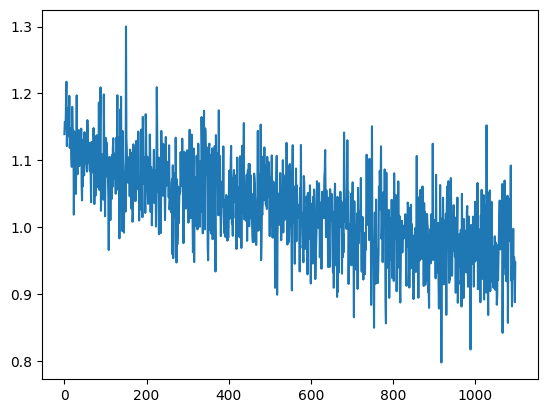

In [50]:
from matplotlib import pyplot as plt
plt.plot(losses)

In [53]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    pad_len = int(getattr(model.config, "phase_pad_len", 0))
    max_ctx = int(block_size) + pad_len

    # ?1 assume space token exists; fallback to 0 if missing
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # prepend the pad once; from now on the window just slides
    if pad_len > 0:
        pad = torch.full((1, pad_len), space_id, dtype=torch.long, device=device)
        idx = torch.cat([pad, start_ids], dim=1)
    else:
        idx = start_ids

    for _ in range(max_new_tokens):
        context = idx[:, -max_ctx:]  # rotating buffer: last pad_len+block_size tokens
        logits, _ = model(context, None)
        last_logits = logits[:, -1, :]
        probs = torch.softmax(last_logits / temperature, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat([idx, next_token], dim=1)

    # drop the initial pad when returning the string
    out_tokens = idx[0, pad_len:].tolist() if pad_len > 0 else idx[0].tolist()
    return decode_chars(out_tokens, itos)
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO: What light through yonder window breaks?\nJuliet, Doth you love me?ROMEO: What light through yonder window breaks?\nJuliet, Doth you love me?"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=4096,
    block_size=1024,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=0.8
)

print(generated)


ROMEO: What light through yonder window breaks?
Juliet, Doth you love me?ROMEO: What light through yonder window breaks?
Juliet, Doth you love me? is both your eyes,
Or best deposed, and stinted hence,
And so disconcile a women and good.

Nurse:
I am for the second bid hell dreams about
True months is more friends, and not in law,
And let us such thinks the sea have state,
That the manner and shapes thus all his foe.

PRINCE:
Gentlemen, good Camillo.

JULIET:
O God! if holy son! but thou wert worthy!

Nurse:
God him not, sweet night, should have it so.

JULIET:
Then should have I had looked this peace to do.

Nurse:
And for what depose shall I go with me:
My lord, I pray you, such a fellow-mate!

JULIET:
Ay, and here beloved me all till I did!

JULIET:
I talk not be, I have shown in your eye's suit:
You have she sweet, and if I should not hold.

JULIET:
As I for the madam, that better tender maid
And thus to the middle of the queen,
Whose punishing, that should he throw for.
Mong weste

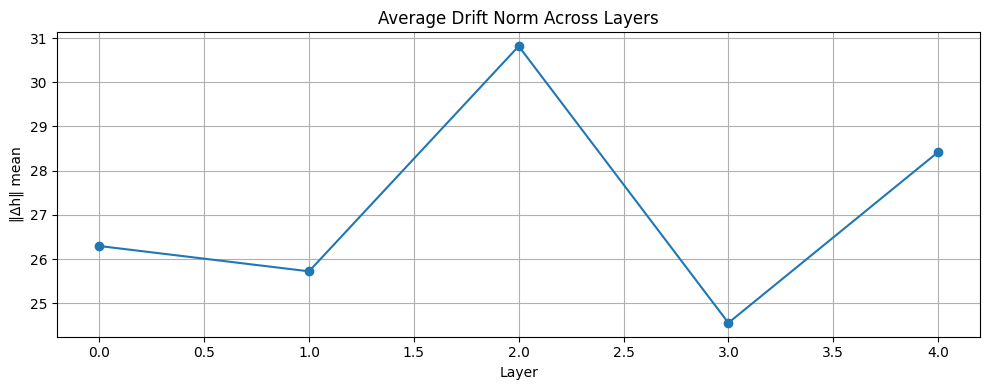

Jacobian rank (final token, projected): 66


In [59]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad
'''
    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        embeddings = torch.cat([self.transformer.wte[i](idx)  for i in range(self.n_head)], dim=-1)
        embeddings = embeddings + pos_emb
        x = self.transformer.drop(embeddings)
        x_orig = x.clone()
        for stage in self.transformer.h:  # stages are ExplorerEngineerStage
          x = stage(x, x_orig)

        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss
'''


@torch.no_grad()
def compute_drift_trajectories(model, idx, pad_token_id=None):
    """
    Drift vectors Δh_l = h_{l+1} - h_l aligned to the shrinking time axis.
    idx: [B, T_visible]
    pad_token_id: pad token id to prepend once (?1 default=0 if None)
    returns: list of arrays, one per layer-gap, each shaped [B]
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()
    pad_len = int(getattr(model.config, "phase_pad_len", 0))
    pad_id = 0 if pad_token_id is None else int(pad_token_id)  # ?1

    # build padded tokens once
    if pad_len > 0:
        pad = torch.full((B, pad_len), pad_id, dtype=idx.dtype, device=device)
        tok = torch.cat([pad, idx], dim=1)  # [B, pad_len+T_vis]
    else:
        tok = idx

    # token + pos emb
    pos = torch.arange(0, tok.size(1), dtype=torch.long, device=device)
    pos_emb = model.transformer.wpe(pos)  # [T_all, C]
    tok_emb = torch.cat([model.transformer.wte[i](tok) for i in range(model.n_head)], dim=-1)
    x = model.transformer.drop(tok_emb + pos_emb)  # [B, T_all, C]

    layers = []
    with torch.no_grad():
        for block in model.transformer.h:
            x = block(x)             # time shrinks by n_head each block (per your setup)
            layers.append(x.clone()) # store aligned outputs

    # compute drifts with alignment: previous tail matches current length
    drifts = []
    for i in range(len(layers) - 1):
        a = layers[i]
        b = layers[i + 1]
        a_aligned = a[:, -b.size(1):, :]
        d = (b - a_aligned)
        drifts.append(d.norm(dim=-1).mean(dim=-1).cpu().numpy())  # [B]
    return drifts


def compute_jacobian_rank(model, idx, projection_dim=324, pad_token_id=None):
    """
    Rank of Jacobian d logits_proj(T_final) / d emb(T_input_last) with pad-once and shrink.
    idx: [B, T_visible]
    pad_token_id: pad token id to prepend once (?2 default=0 if None)
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()
    pad_len = int(getattr(model.config, "phase_pad_len", 0))
    pad_id = 0 if pad_token_id is None else int(pad_token_id)  # ?2

    # build padded tokens once
    if pad_len > 0:
        pad = torch.full((B, pad_len), pad_id, dtype=idx.dtype, device=device)
        tok = torch.cat([pad, idx], dim=1)  # [B, pad_len+T_vis]
    else:
        tok = idx

    # embeddings with grad
    pos = torch.arange(0, tok.size(1), dtype=torch.long, device=device)
    pos_emb = model.transformer.wpe(pos)  # [T_all, C]
    tok_emb = torch.cat([model.transformer.wte[i](tok) for i in range(model.n_head)], dim=-1)
    emb = (tok_emb + pos_emb).requires_grad_(True)

    def forward_emb(emb_input):
        x = model.transformer.drop(emb_input)
        for block in model.transformer.h:
            x = block(x)             # time shrinks each block
        x = model.transformer.ln_f(x)
        logits = model.lm_head(x)    # [B, T_out, V]
        return logits[:, -1, :projection_dim]  # final token after shrink, projected

    output = forward_emb(emb)         # [B, P]
    jac_rows = []
    for i in range(output.shape[-1]):
        go = torch.zeros_like(output)
        go[:, i] = 1.0
        gi = grad(output, emb, grad_outputs=go, retain_graph=True)[0]  # [B, T_all, C]
        jac_rows.append(gi[:, -1, :].detach().cpu().numpy().squeeze()) # grad w.r.t. last input step
    J = np.stack(jac_rows, axis=0)     # [P, C]
    return int(np.linalg.matrix_rank(J))

def plot_drift(drift_norms):
    """
    Plot average drift norm per layer.
    """
    plt.figure(figsize=(10, 4))
    plt.plot([np.mean(d) for d in drift_norms], marker='o')
    plt.title("Average Drift Norm Across Layers")
    plt.xlabel("Layer")
    plt.ylabel("‖Δh‖ mean")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example usage
input_ids = torch.randint(0, model.config.vocab_size, (1, 1024)).to(device)

jac_rank = compute_jacobian_rank(model, input_ids)

drift_norms = compute_drift_trajectories(model, input_ids)
plot_drift(drift_norms)

print("Jacobian rank (final token, projected):", jac_rank)


In [37]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def collect_drift_matrix(model, idx, pad_token_id=None):
    """
    Build a drift matrix by stacking aligned per-layer deltas:
      Δ_l = h_{l+1} - tail_match(h_l)
    Tail-match aligns time since each block trims from the left.

    idx: [B, T_visible]
    pad_token_id: ?1 left-pad token id; default 0 if None
    returns: torch.FloatTensor [N, D] on CPU where N = sum_l B * T_l
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()
    pad_len = int(getattr(model.config, "phase_pad_len", 0))
    pad_id = 0 if pad_token_id is None else int(pad_token_id)  # ?1

    # 1) pad once up front
    if pad_len > 0:
        pad = torch.full((B, pad_len), pad_id, dtype=idx.dtype, device=device)
        tok = torch.cat([pad, idx], dim=1)  # [B, pad_len + T_vis]
    else:
        tok = idx

    # 2) embed like forward() does
    pos = torch.arange(0, tok.size(1), dtype=torch.long, device=device)
    pos_emb = model.transformer.wpe(pos)  # [T_all, C]
    tok_emb = torch.cat([model.transformer.wte[i](tok) for i in range(model.n_head)], dim=-1)  # [B, T_all, C]
    x = model.transformer.drop(tok_emb + pos_emb)

    # 3) collect per-block states (time shrinks each block)
    states = []
    with torch.no_grad():
        for block in model.transformer.h:
            x = block(x)     # length shrinks by your per-layer trim
            states.append(x.clone())

    # 4) aligned drifts: match tail of h_l to h_{l+1}
    drift_chunks = []
    for i in range(len(states) - 1):
        a = states[i]       # [B, T_a, C]
        b = states[i + 1]   # [B, T_b, C], T_b <= T_a
        a_aligned = a[:, -b.size(1):, :]     # tail-match
        d = (b - a_aligned).reshape(-1, b.size(-1))  # [B*T_b, C]
        drift_chunks.append(d.cpu())

    drift_matrix = torch.cat(drift_chunks, dim=0) if drift_chunks else torch.empty(0, tok_emb.size(-1))
    return drift_matrix  # [N, D] on CPU


def run_drift_pca(drift_matrix, k=40):
    """
    PCA on drift samples. drift_matrix can be torch.Tensor [N, D] (CPU or CUDA) or np.ndarray.
    """
    if isinstance(drift_matrix, torch.Tensor):
        drift_np = drift_matrix.detach().cpu().numpy()
    else:
        drift_np = np.asarray(drift_matrix)
    k = min(k, drift_np.shape[0], drift_np.shape[1])  # guard
    pca = PCA(n_components=k)
    pca.fit(drift_np)
    explained = pca.explained_variance_ratio_
    return explained, pca


def plot_explained_variance(explained):
    plt.figure(figsize=(8, 4))
    plt.plot(np.cumsum(explained) * 100, marker='o')
    plt.xlabel("Principal Component")
    plt.ylabel("Cumulative Variance Explained (%)")
    plt.title("Drift Trajectory PCA: Explained Variance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [38]:
from sklearn.mixture import GaussianMixture
import seaborn as sns

def get_projected_residuals(drift_matrix, pca):
    """
    Project Δh onto PCA space and get residuals.
    """
    proj = pca.transform(drift_matrix.numpy())
    recon = pca.inverse_transform(proj)
    residuals = drift_matrix.numpy() - recon
    return proj, residuals

def fit_gmm(proj_data, k=4):
    """
    Fit GMM to PCA-projected drift vectors to identify latent regimes.
    """
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=0)
    gmm.fit(proj_data)
    labels = gmm.predict(proj_data)
    return gmm, labels

def plot_gmm_clusters(proj_data, labels):
    """
    Plot GMM clustering over first 2 PCA components.
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=proj_data[:, 0], y=proj_data[:, 1], hue=labels, palette="tab10", s=10)
    plt.title("Latent Regimes from Drift PCA (GMM Clusters)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


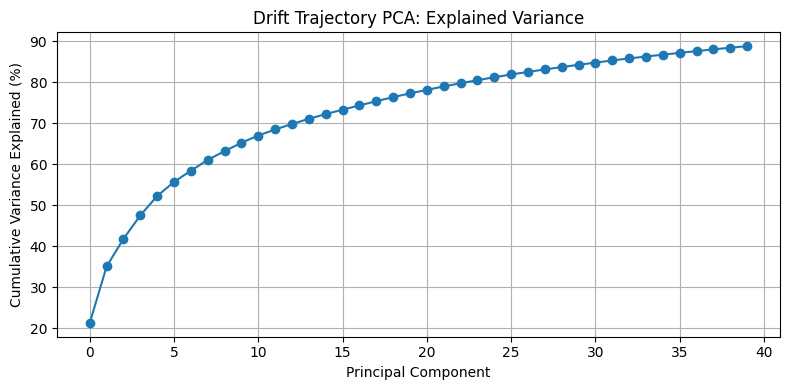

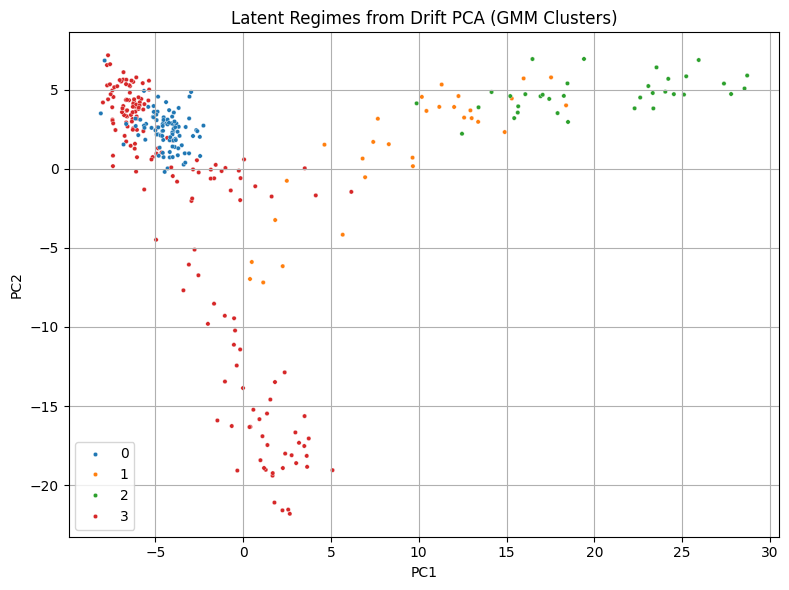

In [57]:
# Inputs
input_ids = torch.randint(0, model.config.vocab_size, (1, model.config.n_head*2)).to(device)

# Drift matrix
drift_matrix = collect_drift_matrix(model, input_ids)

# PCA and variance
explained, pca = run_drift_pca(drift_matrix, k=40)
plot_explained_variance(explained)

# Residuals and GMM regime fit
proj, residuals = get_projected_residuals(drift_matrix, pca)
gmm, labels = fit_gmm(proj, k=4)
plot_gmm_clusters(proj, labels)



🔍 Probe: ['why', 'what', 'where', 'when'] vs who


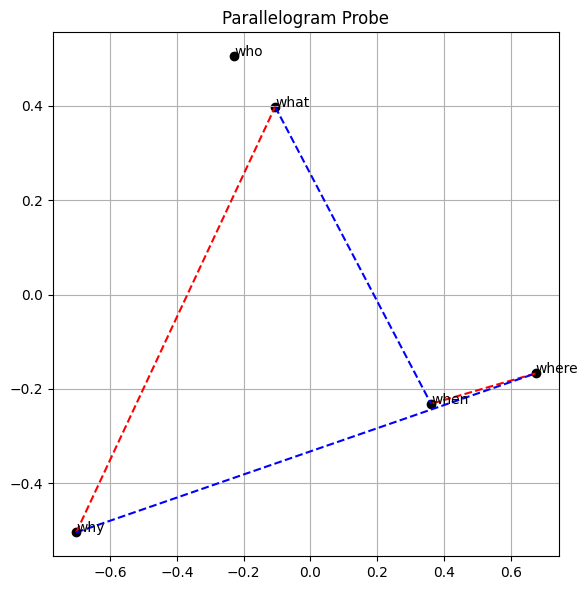


🔍 Probe: ['prepare', 'begin', 'cease', 'end'] vs remain


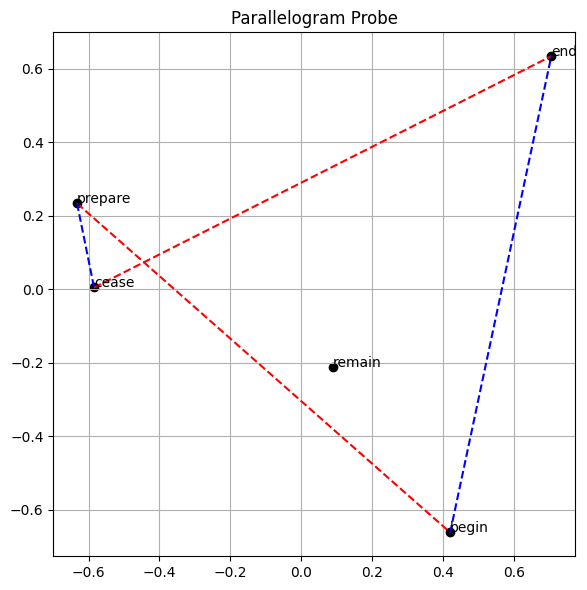


🔍 Probe: ['happy', 'sad', 'disagreeable', 'willing'] vs afraid


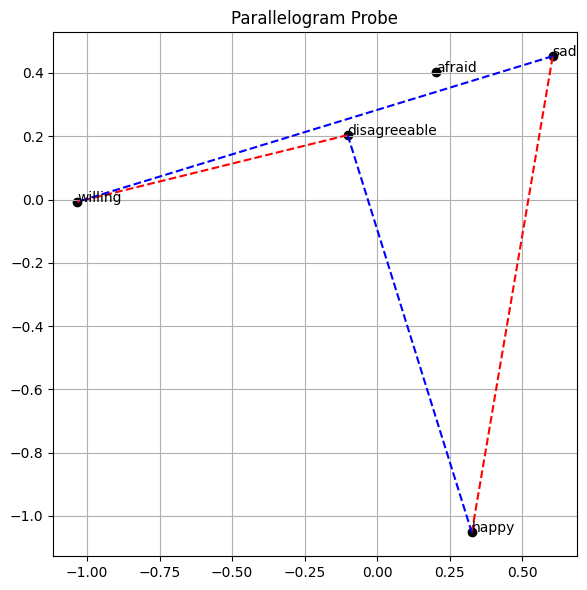


🔍 Probe: ['king', 'queen', 'man', 'woman'] vs apple


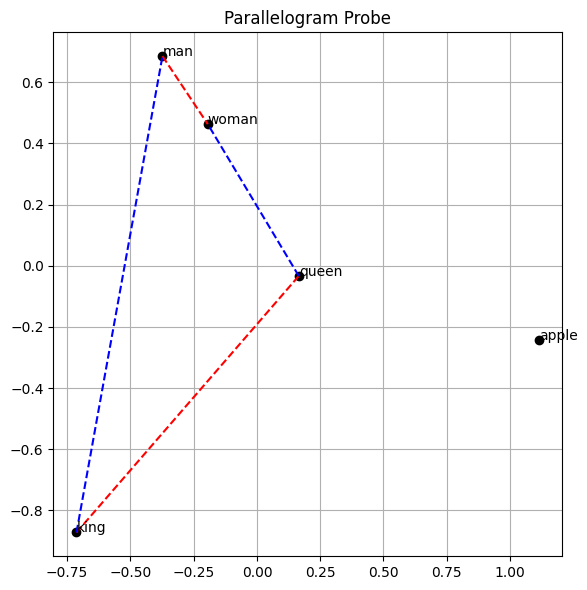


🔍 Probe: ['king', 'knight', 'man', 'maiden'] vs book


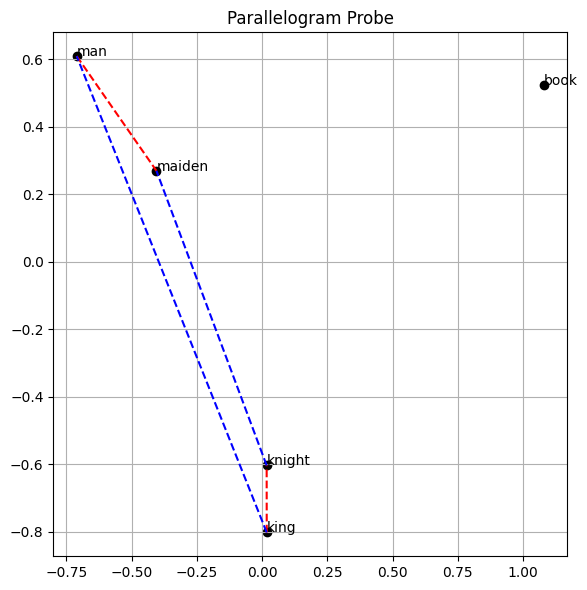


🔍 Probe: ['to', 'from', 'in', 'out'] vs the


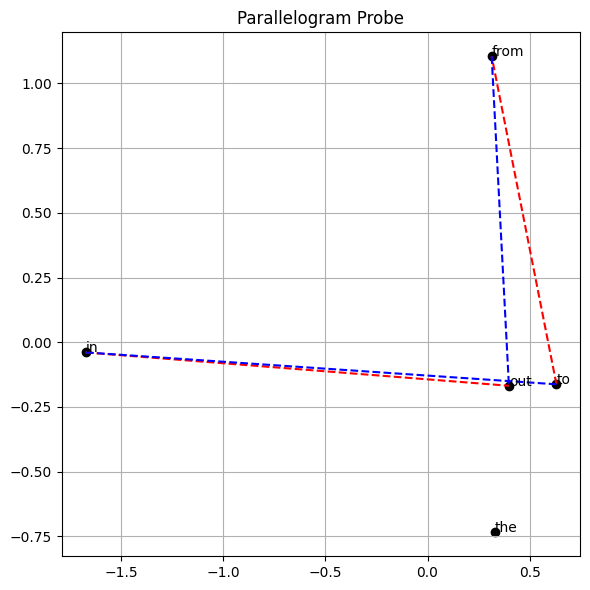

In [56]:
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# === Load vocab ===
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)

stoi = meta["stoi"]
itos = meta["itos"]
device = next(model.parameters()).device
wte = model.transformer.wte

# === Char embedding extractor ===
def get_char_embedding(word):
    ids = [stoi[c] for c in word if c in stoi]
    if not ids:
        return None
    with torch.no_grad():
        emb = torch.cat([model.transformer.wte[i](torch.tensor(ids, dtype=torch.long, device=device).unsqueeze(0))  for i in range(model.n_head)], dim=-1)
        return emb.mean(dim=1).squeeze(0).cpu().numpy()

# === Plot one parallelogram ===
def plot_parallelogram(words, outlier=None):
    vecs = [get_char_embedding(w) for w in words]
    labels = words.copy()
    if outlier:
        vecs.append(get_char_embedding(outlier))
        labels.append(outlier)

    # drop None values
    vecs = [v for v in vecs if v is not None]
    if len(vecs) < 4:
        print(f"⚠️ Not enough valid embeddings for: {labels}")
        return

    vecs = np.stack(vecs)
    proj = PCA(n_components=2).fit_transform(vecs)

    plt.figure(figsize=(6, 6))
    plt.scatter(proj[:, 0], proj[:, 1], color='black')
    for i, label in enumerate(labels):
        plt.text(proj[i, 0], proj[i, 1], label, fontsize=10)

    if len(proj) >= 4:
        A, B, C, D = proj[:4]
        plt.plot([A[0], B[0]], [A[1], B[1]], 'r--')
        plt.plot([C[0], D[0]], [C[1], D[1]], 'r--')
        plt.plot([A[0], C[0]], [A[1], C[1]], 'b--')
        plt.plot([B[0], D[0]], [B[1], D[1]], 'b--')

    plt.title("Parallelogram Probe")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Define test sets ===
test_sets = [
    (["why", "what", "where", "when"], "who"),               # verb→third person
    (["prepare", "begin", "cease", "end"], "remain"),               # singular→plural
    (["happy", "sad", "disagreeable", "willing"], "afraid"),       # negation prefix
    (["king", "queen", "man", "woman"], "apple"),            # gender pairs
    (["king", "knight", "man", "maiden"], "book"),
    (["to", "from", "in", "out"], "the"),                    # function-word symmetry
]

# === Run all probes ===
for words, outlier in test_sets:
    print(f"\n🔍 Probe: {words} vs {outlier}")
    plot_parallelogram(words, outlier)


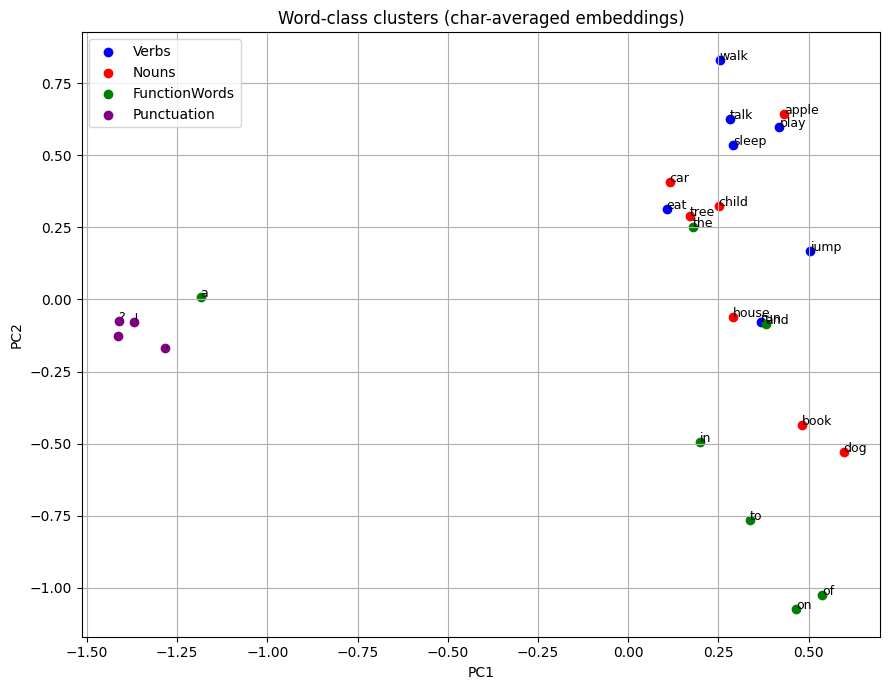

In [55]:
import torch, pickle, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# ---------- load vocab ----------
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi, itos = meta["stoi"], meta["itos"]

# ---------- model bits ----------
device = next(model.parameters()).device
model.eval()                      # <— turn off dropout everywhere
wte = model.transformer.wte
wte.eval()

@torch.no_grad()
def get_char_embedding(word):
    ids = [stoi[c] for c in word if c in stoi]
    if len(ids) < 2:              # ← need ≥2 chars for HailFire geometry
        return None
    with torch.no_grad():
        t = torch.tensor(ids, device=device).unsqueeze(0)      # [1, T]
        emb = torch.cat([model.transformer.wte[i](t)  for i in range(model.n_head)], dim=-1).mean(dim=1).squeeze(0)                    # (d,)
        return emb.cpu().numpy()

# ---------- categories ----------
categories = {
    "Verbs":        ["play","run","eat","sleep","jump","talk","walk"],
    "Nouns":        ["dog","tree","car","book","child","house","apple"],
    "FunctionWords":["the","and","in","on","to","of","a   "],
    "Punctuation":  [".    ",",    ","!    ","?    "],
}

# ---------- gather ----------
vecs, labels, words = [], [], []
for cat, wl in categories.items():
    for w in wl:
        v = get_char_embedding(w)
        if v is not None:
            vecs.append(v)
            labels.append(cat)
            words.append(w)

vecs = np.stack(vecs)             # ← now guaranteed rectangular

# ---------- PCA ----------
proj = PCA(n_components=2).fit_transform(vecs)

# ---------- plot ----------
colors = dict(Verbs="blue", Nouns="red",
              FunctionWords="green", Punctuation="purple")

plt.figure(figsize=(9,7))
for cat in categories:
    idx = [i for i,l in enumerate(labels) if l==cat]
    plt.scatter(proj[idx,0], proj[idx,1], label=cat, color=colors[cat])
    for i in idx:
        plt.text(proj[i,0], proj[i,1], words[i], fontsize=9)

plt.title("Word-class clusters (char-averaged embeddings)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()
def coop2_fn(R: torch.Tensor, C: torch.Tensor,n) -> torch.Tensor:
    x = R**2 + 2*R + C * (1 + R.abs())- R * (1 + C.abs())
    return torch.clamp(x, min=-n-1, max=n+1)

In [54]:
file_path = 'simple_model.pth'

# 3. Save the model's state_dict
torch.save(model.state_dict(), file_path)